# Land-Cover Classification with EuroSAT Dataset


![](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg) 



In this notebook we will tackle the problem of land-use and land-cover classification where we try to identify the class of given remote sensing image based on some well defined target class labels. For training the model we will use the EuroSAT dataset from this [paper](https://arxiv.org/abs/1709.00029) published in 2019 which is now a standard benchmark for land-cover classification task. 

This dataset consisits of 64x64 images captured by Sentinel-2A satellite and it has over **27000 images** spread across **10 classes**. Originally the data consists of hyperspectral images with 13 spectral bands but we will be working with only RGB channels downloaded from [here](http://madm.dfki.de/files/sentinel/EuroSAT.zip). 

The paper states that the finetuned CNN model **ResNet50** performed best with 80-20 split on the data for RGB channels giving about **98.57%** accuracy. 

Finally, this notebook was forked and edited from [here](https://www.kaggle.com/silentj23/eurosat-image-classification#II.-Preprocessing).

**NOTE:** This notebook is still a work in progress so expect a final version soon

In [1]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

# I. Data Exploration

In this project, I'll be exploring the EUROSAT dataset. The EUROSAT dataset is composed of images taken from the Sentinel-2 satellite. This dataset lists images of the earth's surface into 10 different land cover labels. For this project, I will build an image classification model for predicting a land cover label, given an image. 

In [2]:
DATASET = "/kaggle/input/eurosat-rgb/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


# II. Preprocessing

I'd like to evaluate the performance of the model later on after training, so I'll perform a stratified shuffle-split using Scikit-learn to maintain class proportions. 30% of the dataset will be held for evaluation purposes. I'll be loading my data into the Keras model using the ImageDataGenerator class. I'll need the images to be in their own respective land cover directories. 

After splitting the dataset, I'll create some image augmentations using the generator and also denote a subset of the training data to be used as validation data during training. 

In [3]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '../working/training'
TEST_DIR = '../working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

Using TensorFlow backend.


In [4]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('\/kaggle\/input\/eurosat-rgb\/2750', '/kaggle/working/training', i) for i in train_paths]
    new_test_paths = [re.sub('\/kaggle\/input\/eurosat-rgb\/2750', '/kaggle/working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  0%|          | 13/21600 [00:00<02:58, 121.16it/s]

moving training files..


  0%|          | 15/5400 [00:00<00:37, 142.43it/s]

moving testing files..


100%|██████████| 5400/5400 [00:41<00:00, 129.46it/s]


In [5]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [6]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [7]:
np.save('class_indices', train_generator.class_indices)

# IV. Deep Learning For Image Classification

Deep Learning has highly influenced the field of computer vision when Convolutional Neural Networks (CNN) models were used in tasks like image classification, object detection, facial recognition etc. As discussed by authors of EuroSAT paper many deep learning models outperform the traditional non deep learning methods by a large margin. 

In this section we will train many state of the art architectures which performed well on the ILSVRC challenge. The authors achieved an accuracy of 98.57% using a fine tuned ResNet50 model. Here, I will try to employ a similar strategy for training the models where initially the CNN part of the model will be frozen with imagenet weights and dense layers will be trained with a high learning rate of 0.01 and later we will train the whole model end-to-end i.e. fine tune by keeping a small learning rate between 0.001 to 0.0001

Before we start here is a list of CNN models which we will train:
1. ResNet50
2. ResNet50V2
3. ResNet152V2
3. VGG16
4. VGG19

In future
5. InceptionV3
6. Xception

In [8]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [10]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [11]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/kaggle/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

## 4.4 VGG16 Model

In [12]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg16_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________________________

In [13]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/kaggle/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [14]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 43s 126ms/step - loss: 2.1020 - categorical_accuracy: 0.5363 - val_loss: 0.9820 - val_categorical_accuracy: 0.6758

Epoch 00001: val_categorical_accuracy improved from -inf to 0.67578, saving model to /kaggle/working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 40s 119ms/step - loss: 1.1025 - categorical_accuracy: 0.6163 - val_loss: 0.2604 - val_categorical_accuracy: 0.6923

Epoch 00002: val_categorical_accuracy improved from 0.67578 to 0.69228, saving model to /kaggle/working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 40s 118ms/step - loss: 1.0411 - categorical_accuracy: 0.6447 - val_loss: 1.0998 - val_categorical_accuracy: 0.7258

Epoch 00003: val_categorical_accuracy improved from 0.69228 to 0.72582, saving model to /kaggle/working/model.weights.best.hdf5
Epoch 4/50
337/337 [==============================] - 41s 120ms/step - loss: 1.0185 - categorical_accuracy: 0

In [15]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg16_model.load_weights('/kaggle/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - 44s 131ms/step - loss: 1.6009 - categorical_accuracy: 0.4871 - val_loss: 0.0972 - val_categorical_accuracy: 0.7279

Epoch 00001: val_categorical_accuracy did not improve from 0.79385
Epoch 2/100
337/337 [==============================] - 45s 132ms/step - loss: 0.8971 - categorical_accuracy: 0.7088 - val_loss: 0.1363 - val_categorical_accuracy: 0.8416

Epoch 00002: val_categorical_accuracy improved from 0.79385 to 0.84164, saving model to /kaggle/working/model.weights.best.hdf5
Epoch 3/100
337/337 [==============================] - 44s 130ms/step - loss: 0.6152 - categorical_accuracy: 0.8107 - val_loss: 0.5209 - val_categorical_accuracy: 0.8353

Epoch 00003: val_categorical_accuracy did not improve from 0.84164
Epoch 4/100
337/337 [==============================] - 44s 129ms/step - loss: 0.5043 - categorical_accuracy: 0.8520 - val_loss: 0.0823 - val_categorical_accuracy: 0.8714

Epoch 00004: val_categorical_accuracy improved from 0.

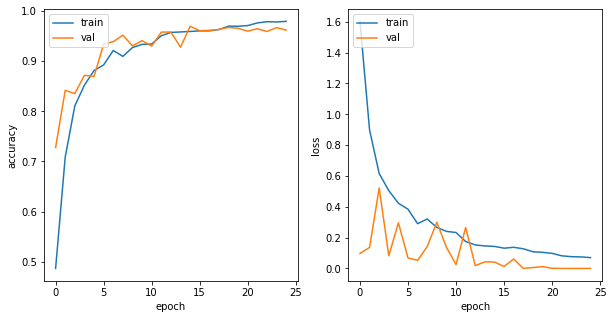

In [16]:
plot_history(vgg16_history)

In [17]:
vgg16_model.load_weights('/kaggle/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.967037037037037
Global F2 Score: 0.967037037037037


Precision    Recall   F-Score  Support
AnnualCrop             0.940345  0.953822  0.947036    628.0
Forest                 0.985050  0.983416  0.984232    603.0
HerbaceousVegetation   0.954939  0.946735  0.950820    582.0
Highway                0.982890  0.960967  0.971805    538.0
Industrial             0.981405  0.965447  0.973361    492.0
Pasture                0.946015  0.973545  0.959583    378.0
PermanentCrop          0.927835  0.937500  0.932642    480.0
Residential            0.982919  0.990610  0.986750    639.0
River                  0.968379  0.978044  0.973188    501.0
SeaLake                0.992727  0.976744  0.984671    559.0

In [18]:
# Save the model and the weights
vgg16_model.save('/kaggle/working/vgg16_eurosat.h5')

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model, Model

# Load the VGG16 model
vgg16_model = load_model('/kaggle/working/vgg16_eurosat.h5')

In [20]:
vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

Found 50 images belonging to 1 classes.
CSV file saved at: /kaggle/working/second_last_layer.csv
CSV file saved at: /kaggle/working/block5_pool.csv
CSV file saved at: /kaggle/working/dense_6.csv


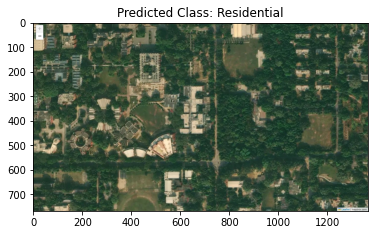

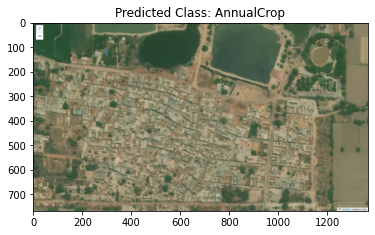

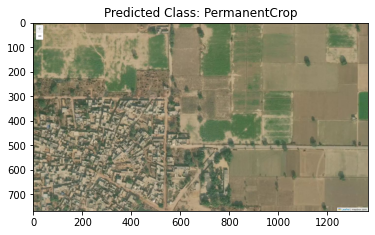

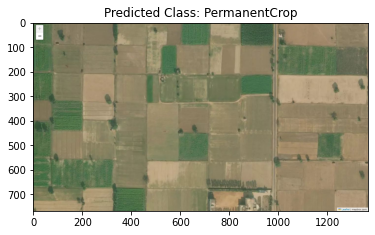

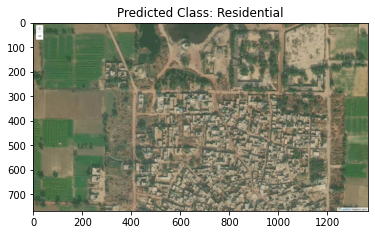

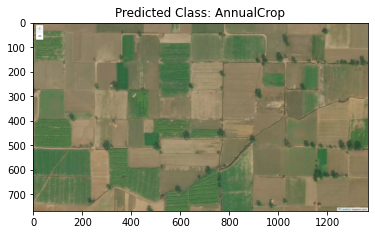

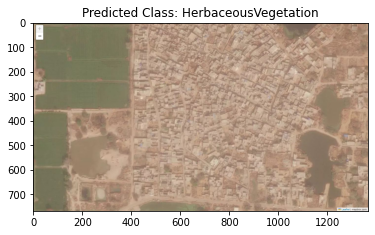

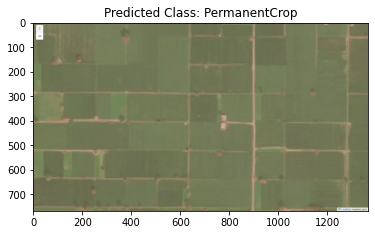

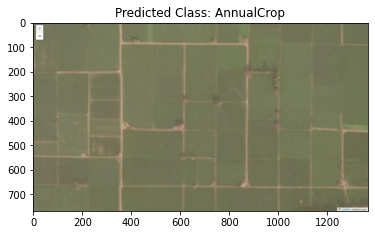

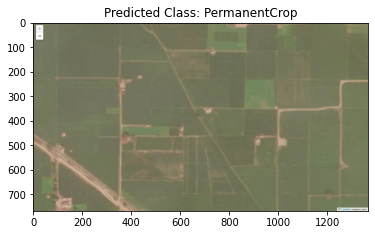

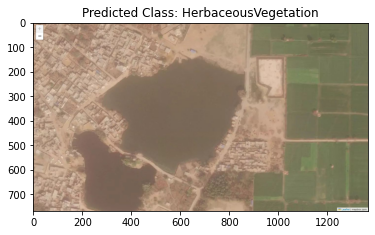

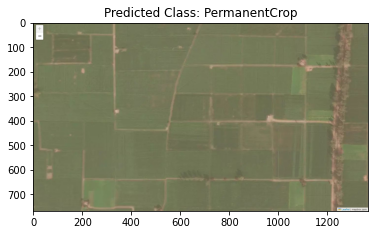

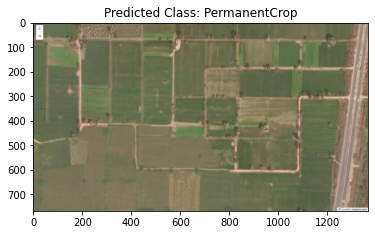

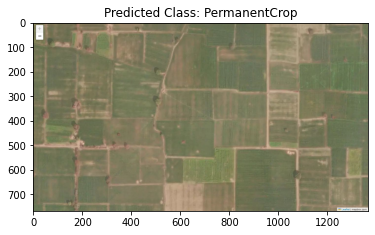

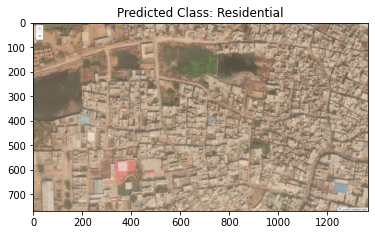

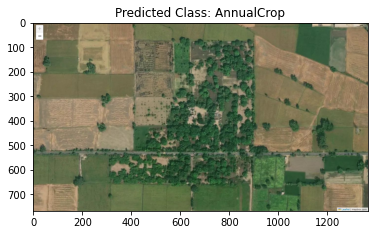

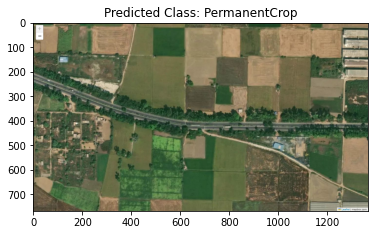

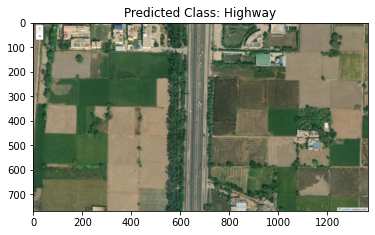

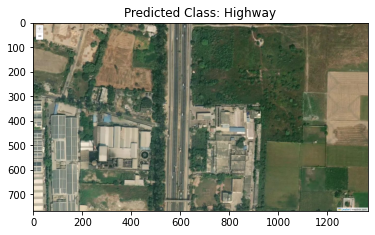

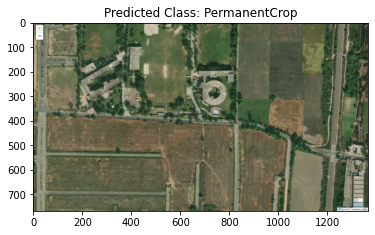

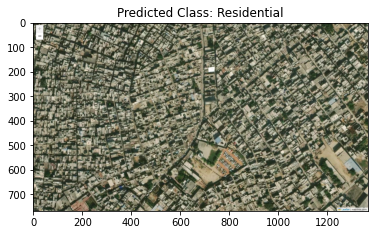

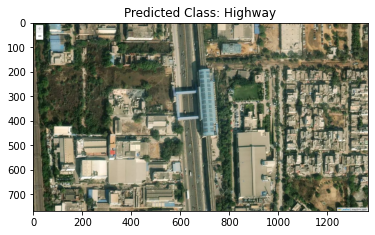

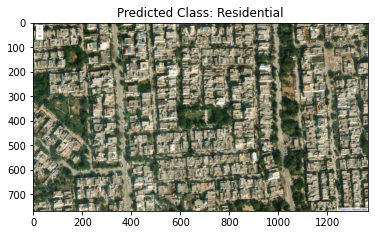

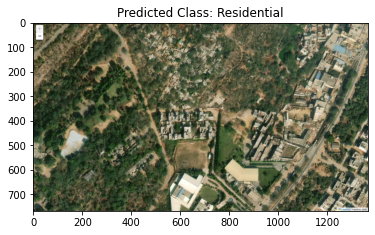

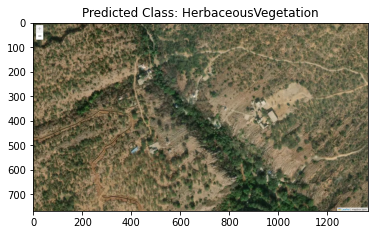

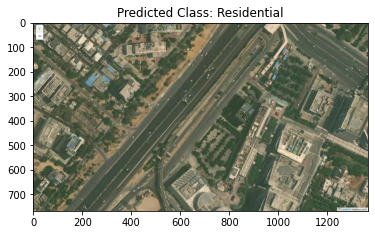

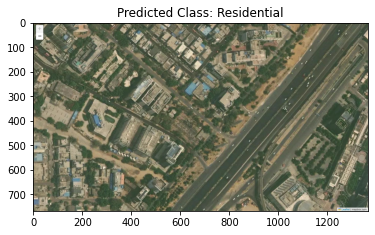

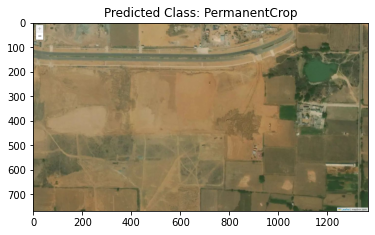

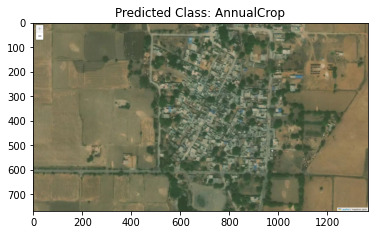

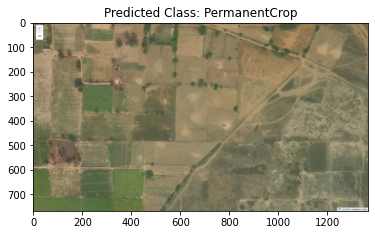

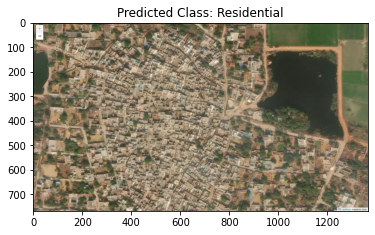

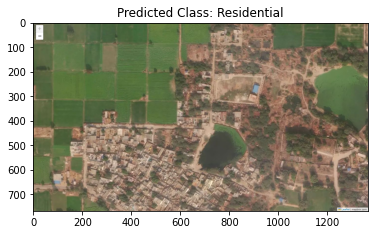

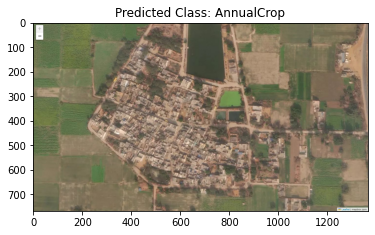

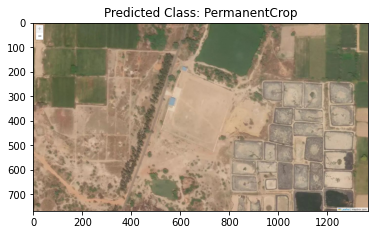

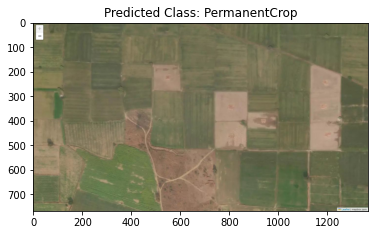

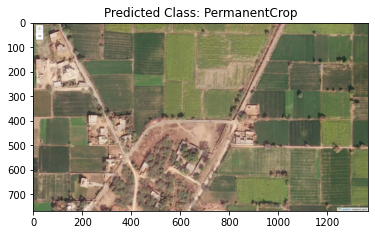

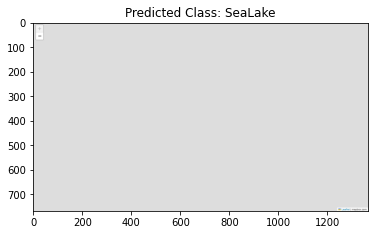

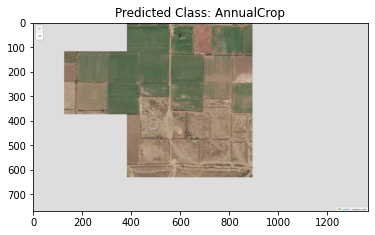

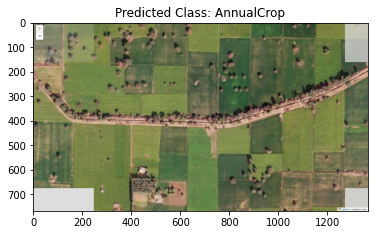

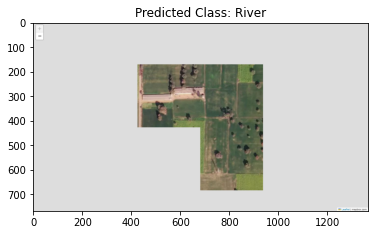

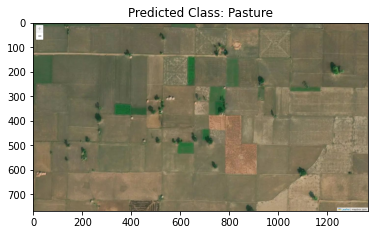

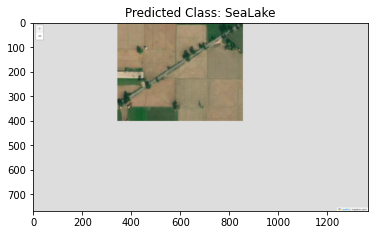

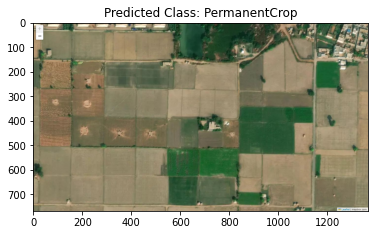

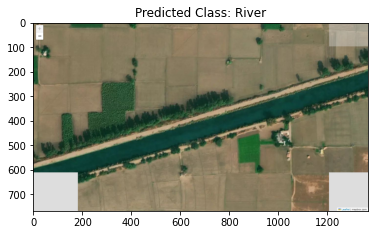

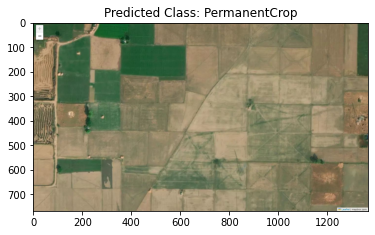

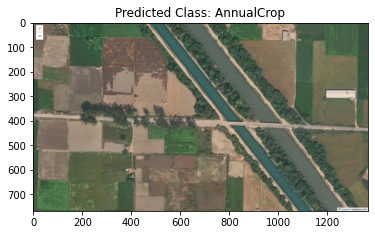

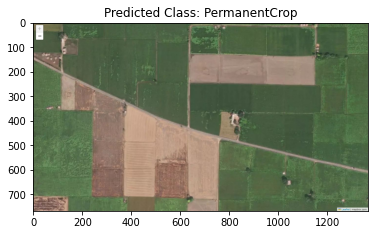

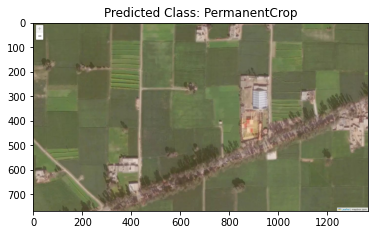

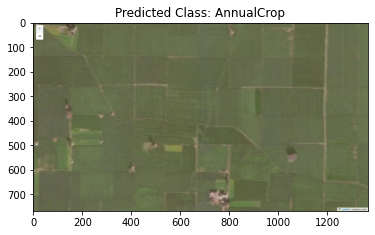

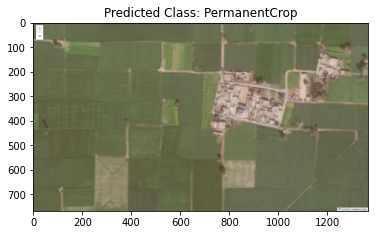

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model, Model

# Load the VGG16 model
vgg16_model = load_model('/kaggle/working/vgg16_eurosat.h5')

# Define the layers for which we want to save the outputs
layers_to_save = {
    'second_last_layer': vgg16_model.get_layer('dropout_2').output,
    'block5_pool': vgg16_model.get_layer('block5_pool').output,
    'dense_6': vgg16_model.get_layer('dense_6').output
}

# Load class indices
class_indices = train_generator.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())

NEW_TEST_DIR = '/kaggle/input/haryanaimagesfinal'

final_gen = ImageDataGenerator(rescale=1./255)

# Function to generate and save CSV for a specific layer
def save_layer_output_csv(layer_name, generator, output_dir, image_paths, predicted_class_names):
    # Extract the desired layer
    selected_layer = Model(inputs=vgg16_model.input, outputs=layers_to_save[layer_name])
    
    # Get the layer outputs for each image
    layer_outputs = selected_layer.predict_generator(generator, steps=len(generator.filenames))

    # Flatten the features for each image
    layer_features_flat = [feat.flatten().tolist() for feat in layer_outputs]

    # Create a dictionary to hold the data for the DataFrame
    data = {'Image Path': image_paths, 'Predicted Class': predicted_class_names}

    # Add each feature as a separate column
    num_features = len(layer_features_flat[0])  # Number of features
    for i in range(num_features):
        data[f'Feature_{i+1}'] = [feat[i] for feat in layer_features_flat]

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    csv_file_path = os.path.join(output_dir, f'{layer_name}.csv')
    df.to_csv(csv_file_path, index=False)
    print(f'CSV file saved at: {csv_file_path}')

# Predictions and second last layer outputs
final_generator = final_gen.flow_from_directory(
    directory=NEW_TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69,
)

# Predict classes for the images
final_predictions = vgg16_model.predict_generator(final_generator, steps=len(final_generator.filenames))
predicted_class_indices = np.argmax(np.rint(final_predictions), axis=1)
predicted_class_names = [class_indices[class_idx] for class_idx in predicted_class_indices]

# Get image paths
image_paths = final_generator.filenames

# Save the outputs for each desired layer
for layer_name in layers_to_save:
    save_layer_output_csv(layer_name, final_generator, '/kaggle/working', image_paths, predicted_class_names)

# Display images with predicted class names
for i in range(len(image_paths)):
    img_path = os.path.join(NEW_TEST_DIR, image_paths[i])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class_names[i]}')
    plt.show()
